In [1]:
# Load the extension, disable it after development
%load_ext autoreload
%autoreload 2

from preprocess import *

import numpy as np
import pandas as pd

from fastdtw import fastdtw
from dtaidistance import dtw

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Game plan
### Reduce complexity or finding time correlations across ips 
We chose agg. window to 15 mins build 96 item vectors
We need fast metric to compute similarities 
Dim reduction + hdbscan or just some other simple clustering


In [5]:
df = pd.read_csv('../data/2019-08-01_test2.csv')
df=df[['ip','timestamp']]

#A = get_aggregated(df, '2019-08-01 00:00:00','2019-08-02 00:00:00')
#A = get_aggregated(df)

tfrom=datetime.datetime.fromisoformat('2019-08-01 00:00:00').timestamp()
tto=datetime.datetime.fromisoformat('2019-08-02 00:00:00').timestamp()

agg_secs = 900
days_proc = 1

A = df.copy()
A = A[(df['timestamp']>=tfrom) & (df['timestamp']<tto)]
#A = A[A['timestamp']<tto]

A['timestamp'] = A.timestamp-tfrom
A['timestamp'] = np.floor(A.timestamp/agg_secs)
Ag = A.groupby('ip')['timestamp'].agg([list, 'count'])

#df['agg']=np.floor(df['timestamp']/900)
#exp=df.groupby('agg')['ip'].agg([set])
#sns.barplot(A['timestamp','count'])

In [7]:
#throw away some data
blocks = 5
data = Ag[Ag['count'] >= blocks] #prefiltered data
#data = Ag
data['series'] = data['list'].apply(get_bin_series, args=[np.int((days_proc * 24 * 3600) / agg_secs)])
data['active'] = data['series'].apply(np.sum)
data['blocks'] = data['series'].apply(count_blocks)

data = data[data['blocks']>=blocks]

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

### Event count distribution analysis

count    27566.000000
mean        33.364870
std        364.036161
min          5.000000
25%          8.000000
50%         13.000000
75%         25.000000
max      55719.000000
Name: count, dtype: float64


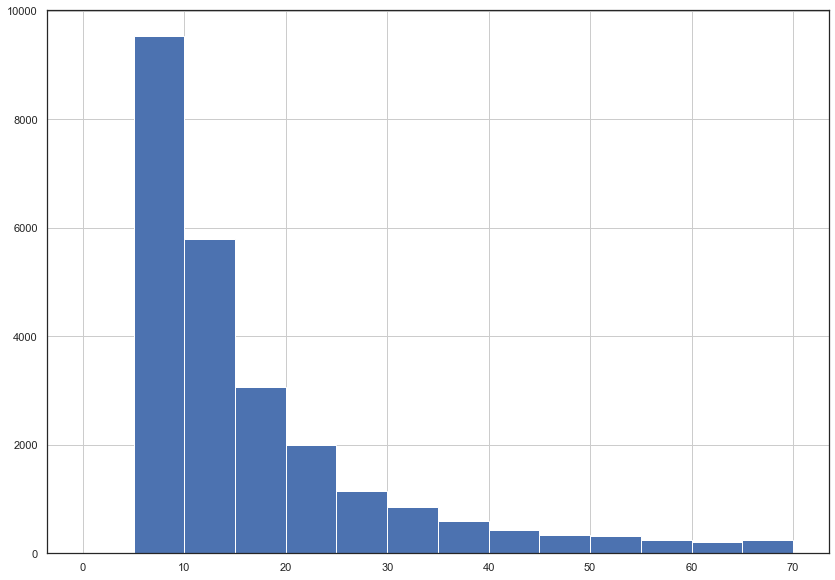

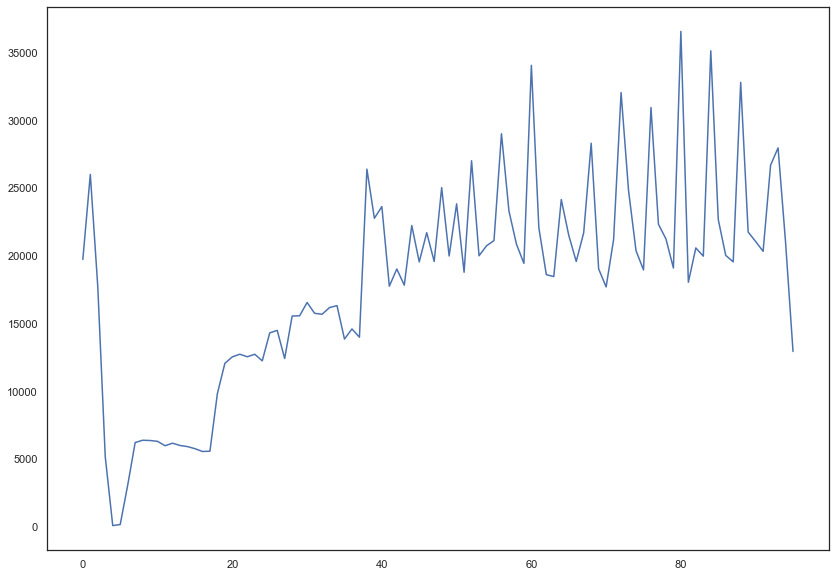

In [10]:
data.head()
print(data['count'].describe())
data['count'].hist(bins=list(range(0,75,5)))
plt.figure()
evt_signal=A.groupby('timestamp')['ip'].agg('count')
sns.lineplot(data=evt_signal)


In [ ]:
data['series']=data['list'].apply(get_bin_series, args=[np.int((days_proc*24*3600)/agg_secs)])

data.sort_values('count', inplace=True, ascending=True)
vect=pd.concat([pd.DataFrame(index=data.index, data=np.stack(data.series)),data['count']], axis=1)

vect=pd.DataFrame(index=data.index, data=np.stack(data.series))

clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(vect)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
           s=0.1, cmap='Spectral')


In [ ]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=50,
    #metric='manhattan'
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

In [ ]:
pd.Series(labels).hist()

data['label']=pd.Series(index=data.index, data=labels)
dataS=data.copy()
dataS.sort_values(['count', 'label'], ascending=True, inplace=True)

